In [33]:
# =========================
# FIGURE 4 (a, b, c) — unified layout, independent data per panel
# Reference styling = panel b/c (line widths, fonts, panel label placement)
# Panel a: PCA (training vs validation) — DEV_165 split (donor-disjoint 80/20)
# Panel b: PCA + decision surface + (0 + SAFE) contours — TRAIN/TEST1/TEST2
# Panel c: PCA + decision surface + ONE dashed contour at FNR10 threshold — TRAIN/TEST2/UNKNOWN
#   - No histogram code in this figure
# =========================

import joblib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [34]:

# =========================
# GLOBAL STYLE (Nature)
# =========================
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1.2,
    "lines.markersize": 4,
})

# =========================
# FIGURE SIZE
# =========================
BASE_WIDTH  = 7.2
BASE_HEIGHT = 2.7
DISPLAY_SCALE = 1.8

# =========================
# COLORS
# =========================
COLORS = {
    "train_0": "#fb9a99",
    "train_1": "#a6cee3",
    "val_0":   "#e31a1c",
    "val_1":   "#1f78b4",
}

POINT_SIZE = 35

# =========================
# THRESHOLDS
# =========================
SAFE_THRESHOLD = -0.6750643265606378
FNR_TARGET_C = 10


In [35]:
# =========================
# PATHS (project root via README.md)
# =========================
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent

DATA_DIR   = ROOT / "data"
MODELS_DIR = ROOT / "models"
NB_OUTPUT  = ROOT / "notebooks" / "outputs_from_notebooks"
NB_OUTPUT.mkdir(parents=True, exist_ok=True)

# --- Panel a (DEV dataset)
DEV_DATA_PATH    = DATA_DIR / "train_165_data_cleaned.csv"
SPLIT_8020_PATH  = NB_OUTPUT / "dev165_split_80_20.csv"

# --- Panel b/c datasets
TRAIN_PATH   = DATA_DIR / "train_165_data.csv"
TEST1_PATH   = DATA_DIR / "test1_data.csv"
TEST2_PATH   = DATA_DIR / "test2_data.csv"
UNKNOWN_PATH = DATA_DIR / "unknown_only.csv"

MODEL_PATH = MODELS_DIR / "final_pipeline_v1_2025-12-09.joblib"
PCA_PATH   = MODELS_DIR / "pca2.joblib"

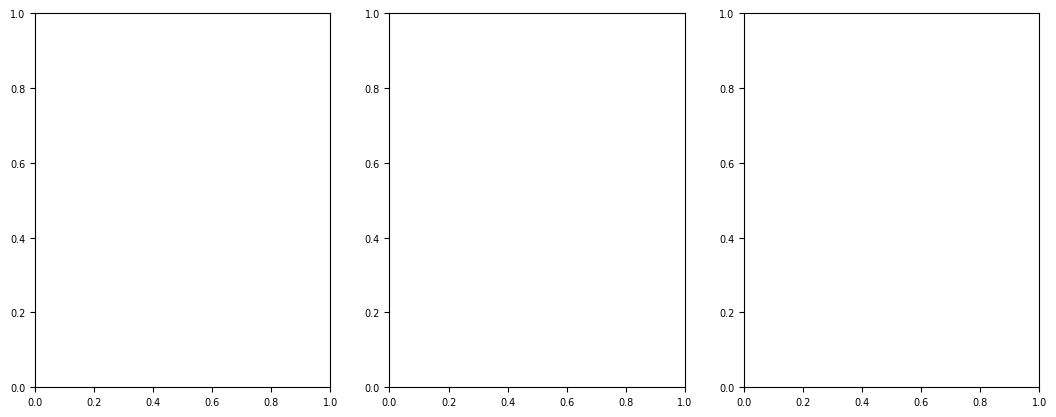

In [36]:
# =========================
# FIGURE 4 — layout
# =========================
fig, axes = plt.subplots(
    1, 3,
    figsize=(BASE_WIDTH * DISPLAY_SCALE,
             BASE_HEIGHT * DISPLAY_SCALE),
    sharex=False,
    sharey=False
)

axA, axB, axC = axes


In [ ]:
# =========================
# PANEL A — PCA (training vs validation) from DEV_165 split
# =========================

dev_df = pd.read_csv(DEV_DATA_PATH, index_col=0)

feature_cols = [
    "BTG3_dCq", "CD69_dCq", "CXCR1_dCq", "CXCR2_dCq",
    "FCGR3_dCq", "JUN_dCq", "STEAP4_dCq"
]

X = dev_df[feature_cols].to_numpy()
y = dev_df["label"].to_numpy()
groups = dev_df["donor_id"].to_numpy()

# --- stable donor-disjoint split
if SPLIT_8020_PATH.exists():
    splits_8020 = pd.read_csv(SPLIT_8020_PATH)
else:
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, cal_idx = next(sgkf.split(X, y, groups))

    splits_8020 = pd.DataFrame({
        "sample_id": dev_df.index.to_list(),
        "donor_id": groups,
        "label": y,
        "role": "train"
    })
    splits_8020.loc[cal_idx, "role"] = "cal"
    splits_8020.to_csv(SPLIT_8020_PATH, index=False)

train_mask = (splits_8020["role"] == "train").to_numpy()
cal_mask   = (splits_8020["role"] == "cal").to_numpy()

X_tr, y_tr = X[train_mask], y[train_mask]
X_cal, y_cal = X[cal_mask], y[cal_mask]

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_cal_s = scaler.transform(X_cal)

pca2 = PCA(n_components=2, random_state=0)
X_tr_pca  = pca2.fit_transform(X_tr_s)
X_cal_pca = pca2.transform(X_cal_s)


# =========================
# DRAW
# =========================
cmap_tr  = ListedColormap([COLORS["train_0"], COLORS["train_1"]])
cmap_cal = ListedColormap([COLORS["val_0"],   COLORS["val_1"]])

axA.scatter(
    X_tr_pca[:, 0], X_tr_pca[:, 1],
    c=y_tr, cmap=cmap_tr,
    marker="o",
    edgecolors="k", linewidths=0.6,
    s=POINT_SIZE
)

axA.scatter(
    X_cal_pca[:, 0], X_cal_pca[:, 1],
    c=y_cal, cmap=cmap_cal,
    marker="^",
    edgecolors="k", linewidths=0.6,
    s=POINT_SIZE
)

axA.set_xlabel("PC1")
axA.set_ylabel("PC2")
axA.set_title("EDTA QC panel (PCA visualization)")

# --- legend: training vs validation (lower left)
leg_tv = [
    Line2D([0], [0], marker="o", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.6, markersize=np.sqrt(POINT_SIZE),
           label="Training"),
    Line2D([0], [0], marker="^", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.6, markersize=np.sqrt(POINT_SIZE),
           label="Validation"),
]

leg1 = axA.legend(
    handles=leg_tv,
    loc="lower left",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)
axA.add_artist(leg1)

# --- legend: intact vs EDTA-altered (lower right)
status_patches = [
    mpatches.Patch(color=COLORS["train_1"], label="Intact mRNA"),
    mpatches.Patch(color=COLORS["train_0"], label="EDTA-altered mRNA"),
]

axA.legend(
    handles=status_patches,
    loc="lower right",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)

# panel label + frame (inline, no helpers)
axA.text(0.0, 1.10, "a", transform=ax.transAxes,
        fontsize=10, fontweight="bold", va="bottom")

for spine in axA.spines.values():
    spine.set_linewidth(0.8)


In [39]:
# =========================
# PANEL B — SVM decision boundary (same PCA as panel C)
# =========================

# --- load data
train_df = pd.read_csv(TRAIN_PATH, index_col=0)
test1_df = pd.read_csv(TEST1_PATH, index_col=0)
test2_df = pd.read_csv(TEST2_PATH, index_col=0)

pipeline = joblib.load(MODEL_PATH)
scaler = pipeline.named_steps["scaler"]
model  = pipeline.named_steps["model"]

pca2 = joblib.load(PCA_PATH)
feature_cols = list(scaler.feature_names_in_)

X_train = train_df[feature_cols]
y_train = train_df["groups"].astype(int).to_numpy()

X_test1 = test1_df[feature_cols]
y_test1 = test1_df["groups"].astype(int).to_numpy()

X_test2 = test2_df[feature_cols]
y_test2 = test2_df["groups"].astype(int).to_numpy()

# --- PCA coordinates
X_train_pca = pca2.transform(scaler.transform(X_train))
X_test1_pca = pca2.transform(scaler.transform(X_test1))
X_test2_pca = pca2.transform(scaler.transform(X_test2))

# --- decision grid (same params as panel C)
pad = 1.0
x_min, x_max = X_train_pca[:, 0].min() - pad, X_train_pca[:, 0].max() + pad
y_min, y_max = X_train_pca[:, 1].min() - pad, X_train_pca[:, 1].max() + pad

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = pca2.inverse_transform(grid_pca)
Z_scores = model.decision_function(grid_scaled).reshape(xx.shape)

# =========================
# DRAW
# =========================

# background
axB.contourf(xx, yy, Z_scores, cmap="coolwarm_r", alpha=0.25)

# decision boundary + safe threshold
axB.contour(xx, yy, Z_scores, levels=[0],
            colors="black", linewidths=0.8)
axB.contour(xx, yy, Z_scores, levels=[SAFE_THRESHOLD],
            colors="black", linewidths=0.8, linestyles="dashed")

# points
axB.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=np.where(y_train == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="x", s=30
)
axB.scatter(
    X_test1_pca[:, 0], X_test1_pca[:, 1],
    c=np.where(y_test1 == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="^", s=35
)
axB.scatter(
    X_test2_pca[:, 0], X_test2_pca[:, 1],
    c=np.where(y_test2 == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="D", s=35
)

axB.set_title("EDTA QC classifier decision boundary and safe threshold")
axB.set_xlabel("PC1")
axB.set_ylabel("PC2")

# panel label + frame (inline)
axB.text(0.0, 1.10, "b", transform=axB.transAxes,
         fontsize=10, fontweight="bold", va="bottom")

for spine in axB.spines.values():
    spine.set_linewidth(0.8)


In [40]:
# =========================
# PANEL C — FNR10 threshold + unknown samples
# =========================

# --- load data
train_df   = pd.read_csv(TRAIN_PATH, index_col=0)
test2_df   = pd.read_csv(TEST2_PATH, index_col=0)
unknown_df = pd.read_csv(UNKNOWN_PATH, index_col=0)

pipeline = joblib.load(MODEL_PATH)
scaler = pipeline.named_steps["scaler"]
model  = pipeline.named_steps["model"]

pca2 = joblib.load(PCA_PATH)
feature_cols = list(scaler.feature_names_in_)

X_train = train_df[feature_cols]
y_train = train_df["groups"].astype(int).to_numpy()

X_test2 = test2_df[feature_cols]
y_test2 = test2_df["groups"].astype(int).to_numpy()

X_unknown = unknown_df[feature_cols]

# --- FNR10 threshold from test2 (bad samples only)
scores_test2 = pipeline.decision_function(X_test2)
bad_scores_test2 = scores_test2[y_test2 == 0]
threshold_fnr10 = float(np.percentile(
    bad_scores_test2, 100 - FNR_TARGET_C
))

# --- PCA coordinates
X_train_pca   = pca2.transform(scaler.transform(X_train))
X_test2_pca   = pca2.transform(scaler.transform(X_test2))
X_unknown_pca = pca2.transform(scaler.transform(X_unknown))

# --- decision grid (same as panel B)
pad = 1.0
x_min, x_max = X_train_pca[:, 0].min() - pad, X_train_pca[:, 0].max() + pad
y_min, y_max = X_train_pca[:, 1].min() - pad, X_train_pca[:, 1].max() + pad

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = pca2.inverse_transform(grid_pca)
Z_scores = model.decision_function(grid_scaled).reshape(xx.shape)

# --- classify unknowns at FNR10
scores_unknown = pipeline.decision_function(X_unknown)
y_unknown_adj = (scores_unknown > threshold_fnr10).astype(int)

# =========================
# DRAW
# =========================

axC.contourf(xx, yy, Z_scores, cmap="coolwarm_r", alpha=0.25)

axC.contour(
    xx, yy, Z_scores,
    levels=[threshold_fnr10],
    colors="black",
    linewidths=0.8,
    linestyles="dashed"
)

axC.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=np.where(y_train == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="x", s=30
)

axC.scatter(
    X_test2_pca[:, 0], X_test2_pca[:, 1],
    c=np.where(y_test2 == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="D", s=35
)

axC.scatter(
    X_unknown_pca[:, 0], X_unknown_pca[:, 1],
    c=np.where(y_unknown_adj == 1, COLORS["val_1"], COLORS["val_0"]),
    marker="o", edgecolors="k", linewidths=0.6, s=35
)

axC.set_title("FNR 10% threshold for unknown samples")
axC.set_xlabel("PC1")
axC.set_ylabel("PC2")

# panel label + frame (inline)
axC.text(0.0, 1.10, "c", transform=axC.transAxes,
         fontsize=10, fontweight="bold", va="bottom")

for spine in axC.spines.values():
    spine.set_linewidth(0.8)


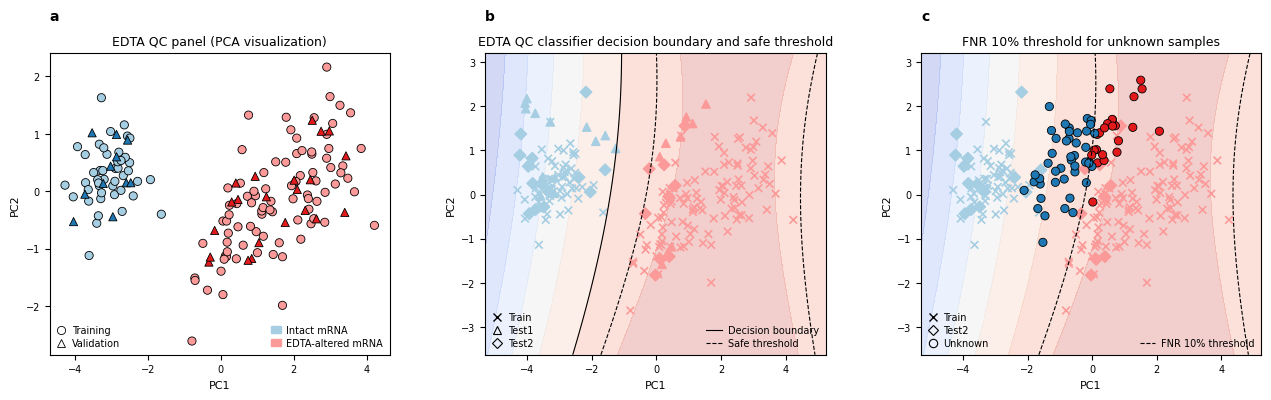

In [42]:
# =========================
# FIGURE 4 — BUILD (a, b, c)  |  Jupyter preview only
# =========================

fig, axes = plt.subplots(
    1, 3,
    figsize=(BASE_WIDTH * DISPLAY_SCALE, BASE_HEIGHT * DISPLAY_SCALE),
    sharex=False, sharey=False
)
axA, axB, axC = axes

# ---- layout spacing (NO tight_layout)
fig.subplots_adjust(left=0.055, right=0.99, bottom=0.20, top=0.82, wspace=0.28)

# ==========================================================
# PANEL A — PCA (training vs validation) from DEV_165 split
# ==========================================================
dev_df = pd.read_csv(DEV_DATA_PATH, index_col=0)

feature_cols = [
    "BTG3_dCq", "CD69_dCq", "CXCR1_dCq", "CXCR2_dCq",
    "FCGR3_dCq", "JUN_dCq", "STEAP4_dCq"
]
X = dev_df[feature_cols].to_numpy()
y = dev_df["label"].to_numpy()
groups = dev_df["donor_id"].to_numpy()

if SPLIT_8020_PATH.exists():
    splits_8020 = pd.read_csv(SPLIT_8020_PATH)
else:
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, cal_idx = next(sgkf.split(X, y, groups))
    splits_8020 = pd.DataFrame({
        "sample_id": dev_df.index.to_list(),
        "donor_id": groups,
        "label": y,
        "role": "train"
    })
    splits_8020.loc[cal_idx, "role"] = "cal"
    splits_8020.to_csv(SPLIT_8020_PATH, index=False)

train_mask = (splits_8020["role"] == "train").to_numpy()
cal_mask   = (splits_8020["role"] == "cal").to_numpy()

X_tr, y_tr = X[train_mask], y[train_mask]
X_cal, y_cal = X[cal_mask], y[cal_mask]

scalerA = StandardScaler()
X_tr_s  = scalerA.fit_transform(X_tr)
X_cal_s = scalerA.transform(X_cal)

pcaA = PCA(n_components=2, random_state=0)
X_tr_pca  = pcaA.fit_transform(X_tr_s)
X_cal_pca = pcaA.transform(X_cal_s)

cmap_tr  = ListedColormap([COLORS["train_0"], COLORS["train_1"]])
cmap_cal = ListedColormap([COLORS["val_0"],   COLORS["val_1"]])

axA.scatter(
    X_tr_pca[:, 0], X_tr_pca[:, 1],
    c=y_tr, cmap=cmap_tr,
    marker="o",
    edgecolors="k", linewidths=0.6,
    s=POINT_SIZE
)
axA.scatter(
    X_cal_pca[:, 0], X_cal_pca[:, 1],
    c=y_cal, cmap=cmap_cal,
    marker="^",
    edgecolors="k", linewidths=0.6,
    s=POINT_SIZE
)

axA.set_xlabel("PC1")
axA.set_ylabel("PC2")
axA.set_title("EDTA QC panel (PCA visualization)")

# panel A legends (as before)
leg_tv = [
    Line2D([0], [0], marker="o", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.6, markersize=np.sqrt(POINT_SIZE), label="Training"),
    Line2D([0], [0], marker="^", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.6, markersize=np.sqrt(POINT_SIZE), label="Validation"),
]
leg1A = axA.legend(
    handles=leg_tv, loc="lower left",
    frameon=False, handlelength=1.0, handletextpad=0.6,
    borderpad=0.2, labelspacing=0.3
)
axA.add_artist(leg1A)

status_patches = [
    mpatches.Patch(color=COLORS["train_1"], label="Intact mRNA"),
    mpatches.Patch(color=COLORS["train_0"], label="EDTA-altered mRNA"),
]
axA.legend(
    handles=status_patches, loc="lower right",
    frameon=False, handlelength=1.0, handletextpad=0.6,
    borderpad=0.2, labelspacing=0.3
)

axA.text(0.0, 1.10, "a", transform=axA.transAxes,
         fontsize=10, fontweight="bold", va="bottom")
for sp in axA.spines.values():
    sp.set_linewidth(0.8)

# ==========================================================
# PANEL B — decision boundary + safe threshold
# ==========================================================
train_df = pd.read_csv(TRAIN_PATH, index_col=0)
test1_df = pd.read_csv(TEST1_PATH, index_col=0)
test2_df = pd.read_csv(TEST2_PATH, index_col=0)

pipelineB = joblib.load(MODEL_PATH)
scalerB = pipelineB.named_steps["scaler"]
modelB  = pipelineB.named_steps["model"]

pca2 = joblib.load(PCA_PATH)
feature_colsB = list(scalerB.feature_names_in_)

X_trainB = train_df[feature_colsB]
y_trainB = train_df["groups"].astype(int).to_numpy()

X_test1B = test1_df[feature_colsB]
y_test1B = test1_df["groups"].astype(int).to_numpy()

X_test2B = test2_df[feature_colsB]
y_test2B = test2_df["groups"].astype(int).to_numpy()

X_train_pcaB = pca2.transform(scalerB.transform(X_trainB))
X_test1_pcaB = pca2.transform(scalerB.transform(X_test1B))
X_test2_pcaB = pca2.transform(scalerB.transform(X_test2B))

pad = 1.0
x_min, x_max = X_train_pcaB[:, 0].min() - pad, X_train_pcaB[:, 0].max() + pad
y_min, y_max = X_train_pcaB[:, 1].min() - pad, X_train_pcaB[:, 1].max() + pad

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = pca2.inverse_transform(grid_pca)
Z_scoresB = modelB.decision_function(grid_scaled).reshape(xx.shape)

axB.contourf(xx, yy, Z_scoresB, cmap="coolwarm_r", alpha=0.25)
axB.contour(xx, yy, Z_scoresB, levels=[0], colors="black", linewidths=0.8)
axB.contour(xx, yy, Z_scoresB, levels=[SAFE_THRESHOLD],
            colors="black", linewidths=0.8, linestyles="dashed")

axB.scatter(
    X_train_pcaB[:, 0], X_train_pcaB[:, 1],
    c=np.where(y_trainB == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="x", s=30
)
axB.scatter(
    X_test1_pcaB[:, 0], X_test1_pcaB[:, 1],
    c=np.where(y_test1B == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="^", s=35
)
axB.scatter(
    X_test2_pcaB[:, 0], X_test2_pcaB[:, 1],
    c=np.where(y_test2B == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="D", s=35
)

axB.set_title("EDTA QC classifier decision boundary and safe threshold")
axB.set_xlabel("PC1")
axB.set_ylabel("PC2")

axB.text(0.0, 1.10, "b", transform=axB.transAxes,
         fontsize=10, fontweight="bold", va="bottom")
for sp in axB.spines.values():
    sp.set_linewidth(0.8)

# ==========================================================
# PANEL C — FNR10 threshold + unknowns
# ==========================================================
unknown_df = pd.read_csv(UNKNOWN_PATH, index_col=0)

X_unknownC = unknown_df[feature_colsB]  # same features as model/scaler
scores_test2C = pipelineB.decision_function(X_test2B)

bad_scores_test2 = scores_test2C[y_test2B == 0]
threshold_fnr10 = float(np.percentile(bad_scores_test2, 100 - FNR_TARGET_C))

X_unknown_pcaC = pca2.transform(scalerB.transform(X_unknownC))
Z_scoresC = Z_scoresB  # same grid as panel B (same xx/yy/grid)

scores_unknown = pipelineB.decision_function(X_unknownC)
y_unknown_adj = (scores_unknown > threshold_fnr10).astype(int)

axC.contourf(xx, yy, Z_scoresC, cmap="coolwarm_r", alpha=0.25)
axC.contour(xx, yy, Z_scoresC, levels=[threshold_fnr10],
            colors="black", linewidths=0.8, linestyles="dashed")

axC.scatter(
    X_train_pcaB[:, 0], X_train_pcaB[:, 1],
    c=np.where(y_trainB == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="x", s=30
)
axC.scatter(
    X_test2_pcaB[:, 0], X_test2_pcaB[:, 1],
    c=np.where(y_test2B == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="D", s=35
)
axC.scatter(
    X_unknown_pcaC[:, 0], X_unknown_pcaC[:, 1],
    c=np.where(y_unknown_adj == 1, COLORS["val_1"], COLORS["val_0"]),
    marker="o", edgecolors="k", linewidths=0.6, s=35
)

axC.set_title("FNR 10% threshold for unknown samples")
axC.set_xlabel("PC1")
axC.set_ylabel("PC2")

axC.text(0.0, 1.10, "c", transform=axC.transAxes,
         fontsize=10, fontweight="bold", va="bottom")
for sp in axC.spines.values():
    sp.set_linewidth(0.8)

# ==========================================================
# LEGENDS — panel b + panel c (unchanged positions)
# ==========================================================

# Panel b: left bottom (samples)
leg_b_samples = [
    Line2D([0], [0], marker="x", linestyle="None",
           color="black", markersize=6, label="Train"),
    Line2D([0], [0], marker="^", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=6, label="Test1"),
    Line2D([0], [0], marker="D", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=5, label="Test2"),
]
leg1 = axB.legend(
    handles=leg_b_samples,
    loc="lower left",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)
axB.add_artist(leg1)

# Panel b: right bottom (lines)
leg_b_lines = [
    Line2D([0], [0], color="black", linestyle="solid",
           linewidth=0.8, label="Decision boundary"),
    Line2D([0], [0], color="black", linestyle="dashed",
           linewidth=0.8, label="Safe threshold"),
]
axB.legend(
    handles=leg_b_lines,
    loc="lower right",
    frameon=False,
    handlelength=1.6,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)

# Panel c: left bottom (samples)
leg_c_samples = [
    Line2D([0], [0], marker="x", linestyle="None",
           color="black", markersize=6, label="Train"),
    Line2D([0], [0], marker="D", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=5, label="Test2"),
    Line2D([0], [0], marker="o", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=6, label="Unknown"),
]
legc1 = axC.legend(
    handles=leg_c_samples,
    loc="lower left",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)
axC.add_artist(legc1)

# Panel c: right bottom (line)
leg_c_line = [
    Line2D([0], [0], color="black", linestyle="dashed",
           linewidth=0.8, label=f"FNR {FNR_TARGET_C}% threshold"),
]
axC.legend(
    handles=leg_c_line,
    loc="lower right",
    frameon=False,
    handlelength=1.6,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)

plt.show()


----

stejná logika jako u obrázku 1, úplně stejné velikosti

In [ ]:
# =========================
# FIGURE 4 — BUILD (Fig1-style: ONE figure, ONE size, tight_layout)
# =========================

# ---- ONE figure only (same as Fig1: scaled canvas used for both preview + export)
fig, axes = plt.subplots(
    1, 3,
    figsize=(BASE_WIDTH * DISPLAY_SCALE, BASE_HEIGHT * DISPLAY_SCALE),
    sharex=False,
    sharey=False
)
axA, axB, axC = axes

# ==========================================================
# PANEL A — PCA (training vs validation) from DEV_165 split
# ==========================================================
dev_df = pd.read_csv(DEV_DATA_PATH, index_col=0)

feature_cols_A = [
    "BTG3_dCq", "CD69_dCq", "CXCR1_dCq", "CXCR2_dCq",
    "FCGR3_dCq", "JUN_dCq", "STEAP4_dCq"
]
X = dev_df[feature_cols_A].to_numpy()
y = dev_df["label"].to_numpy()
groups = dev_df["donor_id"].to_numpy()

# stable donor-disjoint split
if SPLIT_8020_PATH.exists():
    splits_8020 = pd.read_csv(SPLIT_8020_PATH)
else:
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, cal_idx = next(sgkf.split(X, y, groups))
    splits_8020 = pd.DataFrame({
        "sample_id": dev_df.index.to_list(),
        "donor_id": groups,
        "label": y,
        "role": "train"
    })
    splits_8020.loc[cal_idx, "role"] = "cal"
    splits_8020.to_csv(SPLIT_8020_PATH, index=False)

train_mask = (splits_8020["role"] == "train").to_numpy()
cal_mask   = (splits_8020["role"] == "cal").to_numpy()

X_tr, y_tr = X[train_mask], y[train_mask]
X_cal, y_cal = X[cal_mask], y[cal_mask]

scalerA = StandardScaler()
X_tr_s  = scalerA.fit_transform(X_tr)
X_cal_s = scalerA.transform(X_cal)

pcaA = PCA(n_components=2, random_state=0)
X_tr_pca  = pcaA.fit_transform(X_tr_s)
X_cal_pca = pcaA.transform(X_cal_s)

cmap_tr  = ListedColormap([COLORS["train_0"], COLORS["train_1"]])
cmap_cal = ListedColormap([COLORS["val_0"],   COLORS["val_1"]])

axA.scatter(
    X_tr_pca[:, 0], X_tr_pca[:, 1],
    c=y_tr, cmap=cmap_tr,
    marker="o",
    edgecolors="k", linewidths=0.6,
    s=POINT_SIZE
)
axA.scatter(
    X_cal_pca[:, 0], X_cal_pca[:, 1],
    c=y_cal, cmap=cmap_cal,
    marker="^",
    edgecolors="k", linewidths=0.6,
    s=POINT_SIZE
)

axA.set_xlabel("PC1")
axA.set_ylabel("PC2")
axA.set_title("EDTA QC panel (PCA visualization)")

# legend: training vs validation (lower left)
leg_tv = [
    Line2D([0], [0], marker="o", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.6, markersize=np.sqrt(POINT_SIZE),
           label="Training"),
    Line2D([0], [0], marker="^", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.6, markersize=np.sqrt(POINT_SIZE),
           label="Validation"),
]
leg1A = axA.legend(
    handles=leg_tv,
    loc="lower left",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)
axA.add_artist(leg1A)

# legend: intact vs EDTA-altered (lower right)
status_patches = [
    mpatches.Patch(color=COLORS["train_1"], label="Intact mRNA"),
    mpatches.Patch(color=COLORS["train_0"], label="EDTA-altered mRNA"),
]
axA.legend(
    handles=status_patches,
    loc="lower right",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)

# frame
for sp in axA.spines.values():
    sp.set_linewidth(0.8)

# ==========================================================
# PANEL B — decision boundary + safe threshold
# ==========================================================
train_df = pd.read_csv(TRAIN_PATH, index_col=0)
test1_df = pd.read_csv(TEST1_PATH, index_col=0)
test2_df = pd.read_csv(TEST2_PATH, index_col=0)

pipeline = joblib.load(MODEL_PATH)
scalerB = pipeline.named_steps["scaler"]
modelB  = pipeline.named_steps["model"]

pca2 = joblib.load(PCA_PATH)
feature_cols_B = list(scalerB.feature_names_in_)

X_trainB = train_df[feature_cols_B]
y_trainB = train_df["groups"].astype(int).to_numpy()

X_test1B = test1_df[feature_cols_B]
y_test1B = test1_df["groups"].astype(int).to_numpy()

X_test2B = test2_df[feature_cols_B]
y_test2B = test2_df["groups"].astype(int).to_numpy()

X_train_pcaB = pca2.transform(scalerB.transform(X_trainB))
X_test1_pcaB = pca2.transform(scalerB.transform(X_test1B))
X_test2_pcaB = pca2.transform(scalerB.transform(X_test2B))

# decision grid (shared with panel C)
pad = 1.0
x_min, x_max = X_train_pcaB[:, 0].min() - pad, X_train_pcaB[:, 0].max() + pad
y_min, y_max = X_train_pcaB[:, 1].min() - pad, X_train_pcaB[:, 1].max() + pad

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = pca2.inverse_transform(grid_pca)
Z_scores = modelB.decision_function(grid_scaled).reshape(xx.shape)

axB.contourf(xx, yy, Z_scores, cmap="coolwarm_r", alpha=0.25)
axB.contour(xx, yy, Z_scores, levels=[0], colors="black", linewidths=0.8)
axB.contour(xx, yy, Z_scores, levels=[SAFE_THRESHOLD],
            colors="black", linewidths=0.8, linestyles="dashed")

axB.scatter(
    X_train_pcaB[:, 0], X_train_pcaB[:, 1],
    c=np.where(y_trainB == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="x", s=30
)
axB.scatter(
    X_test1_pcaB[:, 0], X_test1_pcaB[:, 1],
    c=np.where(y_test1B == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="^", s=35
)
axB.scatter(
    X_test2_pcaB[:, 0], X_test2_pcaB[:, 1],
    c=np.where(y_test2B == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="D", s=35
)

axB.set_title("EDTA QC classifier decision boundary and safe threshold")
axB.set_xlabel("PC1")
axB.set_ylabel("PC2")

for sp in axB.spines.values():
    sp.set_linewidth(0.8)

# ==========================================================
# PANEL C — FNR10 threshold + unknown samples
# ==========================================================
unknown_df = pd.read_csv(UNKNOWN_PATH, index_col=0)
X_unknownC = unknown_df[feature_cols_B]

scores_test2 = pipeline.decision_function(X_test2B)
bad_scores_test2 = scores_test2[y_test2B == 0]
threshold_fnr10 = float(np.percentile(bad_scores_test2, 100 - FNR_TARGET_C))

X_unknown_pcaC = pca2.transform(scalerB.transform(X_unknownC))

scores_unknown = pipeline.decision_function(X_unknownC)
y_unknown_adj = (scores_unknown > threshold_fnr10).astype(int)

axC.contourf(xx, yy, Z_scores, cmap="coolwarm_r", alpha=0.25)
axC.contour(xx, yy, Z_scores, levels=[threshold_fnr10],
            colors="black", linewidths=0.8, linestyles="dashed")

axC.scatter(
    X_train_pcaB[:, 0], X_train_pcaB[:, 1],
    c=np.where(y_trainB == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="x", s=30
)
axC.scatter(
    X_test2_pcaB[:, 0], X_test2_pcaB[:, 1],
    c=np.where(y_test2B == 1, COLORS["train_1"], COLORS["train_0"]),
    marker="D", s=35
)
axC.scatter(
    X_unknown_pcaC[:, 0], X_unknown_pcaC[:, 1],
    c=np.where(y_unknown_adj == 1, COLORS["val_1"], COLORS["val_0"]),
    marker="o", edgecolors="k", linewidths=0.6, s=35
)

axC.set_title("FNR 10% threshold for unknown samples")
axC.set_xlabel("PC1")
axC.set_ylabel("PC2")

for sp in axC.spines.values():
    sp.set_linewidth(0.8)

# ==========================================================
# LEGENDS — panel b + panel c (unchanged positions)
# ==========================================================
# Panel b: left bottom (samples)
leg_b_samples = [
    Line2D([0], [0], marker="x", linestyle="None",
           color="black", markersize=6, label="Train"),
    Line2D([0], [0], marker="^", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=6, label="Test1"),
    Line2D([0], [0], marker="D", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=5, label="Test2"),
]
leg1B = axB.legend(
    handles=leg_b_samples,
    loc="lower left",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)
axB.add_artist(leg1B)

# Panel b: right bottom (lines)
leg_b_lines = [
    Line2D([0], [0], color="black", linestyle="solid",
           linewidth=0.8, label="Decision boundary"),
    Line2D([0], [0], color="black", linestyle="dashed",
           linewidth=0.8, label="Safe threshold"),
]
axB.legend(
    handles=leg_b_lines,
    loc="lower right",
    frameon=False,
    handlelength=1.6,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)

# Panel c: left bottom (samples)
leg_c_samples = [
    Line2D([0], [0], marker="x", linestyle="None",
           color="black", markersize=6, label="Train"),
    Line2D([0], [0], marker="D", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=5, label="Test2"),
    Line2D([0], [0], marker="o", linestyle="None",
           markerfacecolor="none", markeredgecolor="black",
           markeredgewidth=0.8, color="none",
           markersize=6, label="Unknown"),
]
leg1C = axC.legend(
    handles=leg_c_samples,
    loc="lower left",
    frameon=False,
    handlelength=1.0,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)
axC.add_artist(leg1C)

# Panel c: right bottom (line)
leg_c_line = [
    Line2D([0], [0], color="black", linestyle="dashed",
           linewidth=0.8, label=f"FNR {FNR_TARGET_C}% threshold"),
]
axC.legend(
    handles=leg_c_line,
    loc="lower right",
    frameon=False,
    handlelength=1.6,
    handletextpad=0.6,
    borderpad=0.2,
    labelspacing=0.3
)

# ==========================================================
# PANEL LABELS (Fig1-style)
# ==========================================================
for label, ax in zip(["a", "b", "c"], [axA, axB, axC]):
    ax.text(
        0.0, 1.10, label,
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="bottom"
    )

# Fig1-style layout step (same rect logic)
fig.tight_layout(rect=(0, 0.10, 1, 1))

plt.show()


In [ ]:
# =========================
# FIGURE 4 — EXPORT (Fig1-style)
# =========================
out = NB_OUTPUT / "FIGURE4"

fig.savefig(str(out) + ".pdf", bbox_inches="tight")
fig.savefig(str(out) + ".png", dpi=300, bbox_inches="tight")
fig.savefig(str(out) + ".svg", bbox_inches="tight")
